In [219]:
# Sezione 0: Import librerie aggiuntive
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error
from scipy import sparse
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [220]:
# Sezione 1: Caricamento dati (MovieLens 100k)
url = "../datasets/ml-100k/u.data"
columns = ['user_id', 'movie_id', 'rating', 'timestamp']
df = pd.read_csv(url, sep='\t', names=columns)
df.drop(columns='timestamp', inplace=True)

In [221]:
# Sezione 2: Matrice utente-item e sparsità
ratings_matrix = df.pivot_table(index='user_id', columns='movie_id', values='rating')
n_users, n_items = ratings_matrix.shape
nnz = ratings_matrix.count().sum()
sparsity = 1 - nnz / (n_users * n_items)
print(f"Numero utenti: {n_users}, Numero item: {n_items}")
print(f"Ratings non nulli: {nnz}")
print(f"Sparsità: {sparsity:.2%}")

Numero utenti: 943, Numero item: 1682
Ratings non nulli: 100000
Sparsità: 93.70%


In [222]:
# Sezione 3: Gestione della sparsità con SVD (se necessario)
threshold_sparsity = 0.85
if sparsity > threshold_sparsity:
    R_filled = ratings_matrix.fillna(0)
    R_sparse = sparse.csr_matrix(R_filled.values)
    u_svd, s_svd, vt_svd = svds(R_sparse, k=50)
    R_svd = u_svd.dot(np.diag(s_svd)).dot(vt_svd)
    ratings_matrix = pd.DataFrame(R_svd, index=ratings_matrix.index, columns=ratings_matrix.columns)
    nnz_svd = np.count_nonzero(ratings_matrix.values)
    sparsity_svd = 1 - nnz_svd / ratings_matrix.size
    print("SVD applicato: matrice ricostruita densa.")
    print(f"Sparsità dopo SVD: {sparsity_svd:.2%}")
else:
    ratings_matrix = ratings_matrix.fillna(0)
    print("Sparsità accettabile: nessuna SVD necessaria.")

SVD applicato: matrice ricostruita densa.
Sparsità dopo SVD: 0.00%


In [223]:

# Sezione 4: Split train/test e train_matrix
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_matrix = train_data.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)

In [224]:

# Sezione 5: Calcolo similarity user/item
sim_cosine_u = cosine_similarity(train_matrix)
R_centered = train_matrix.sub(train_matrix.mean(axis=1), axis=0)
sim_pearson_u = 1 - pairwise_distances(R_centered.fillna(0), metric='correlation')
user_similarity = pd.DataFrame(sim_pearson_u, index=train_matrix.index, columns=train_matrix.index)
item_similarity = pd.DataFrame(cosine_similarity(train_matrix.T), index=train_matrix.columns, columns=train_matrix.columns)

In [225]:

# Sezione 5.1: Clustering utenti con PCA + KMeans
global_features = R_centered.fillna(0).values
scaled = StandardScaler().fit_transform(global_features)
pca = PCA(n_components=20, random_state=42)
features_pca = pca.fit_transform(scaled)

sil_scores = []
for k in range(2, 21):
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(features_pca)
    sil_scores.append(silhouette_score(features_pca, labels))
best_k = np.argmax(sil_scores) + 2
print(f"Silhouette Score migliore: {max(sil_scores):.4f} con k = {best_k}")

user_clusters = pd.Series(KMeans(n_clusters=best_k, random_state=42).fit_predict(features_pca), index=train_matrix.index)

Silhouette Score migliore: 0.5356 con k = 2


In [226]:
# Sezione 6: Funzioni di predizione CF
sim_threshold = 0.1
def predict_user_cf(u, i, R, sim, means, clusters):
    same = clusters[clusters == clusters[u]].index
    sims = sim.loc[u, same]
    sims = sims[sims > sim_threshold].sort_values(ascending=False)
    num = den = 0.0
    for v, s in sims.items():
        r = R.loc[v, i] if i in R.columns else 0
        if r > 0:
            num += s * (r - means[v])
            den += abs(s)
    return means[u] if den == 0 else means[u] + num/den

def predict_item_cf(u, i, R, sim, means):
    if i not in sim.index or i not in R.columns:
        return means.get(u, 0)
    sims = sim[i].sort_values(ascending=False)
    num = den = 0.0
    for j, s in sims.items():
        r = R.loc[u, j] if j in R.columns else 0
        if r > 0:
            num += s * (r - means[u])
            den += abs(s)
    return means[u] if den == 0 else means[u] + num/den

user_means = train_matrix.replace(0, np.nan).mean(axis=1).fillna(0)

def hybrid_predict(u, i):
    ub = predict_user_cf(u, i, train_matrix, user_similarity, user_means, user_clusters)
    ib = predict_item_cf(u, i, train_matrix, item_similarity, user_means)
    return 0.5 * ub + 0.5 * ib


In [227]:
# Sezione 7: Valutazione rating (MAE, RMSE, Accuracy...)
threshold = 4
y_true_bin, y_pred_bin, y_true_cont, y_pred_cont = [], [], [], []
for _, row in test_data.iterrows():
    u, i, true_r = row.user_id, row.movie_id, row.rating
    pred_r = hybrid_predict(u, i)
    y_true_cont.append(true_r); y_pred_cont.append(pred_r)
    y_true_bin.append(1 if true_r >= threshold else 0); y_pred_bin.append(1 if pred_r >= threshold else 0)
accuracy = accuracy_score(y_true_bin, y_pred_bin)
precision = precision_score(y_true_bin, y_pred_bin, zero_division=0)
recall = recall_score(y_true_bin, y_pred_bin, zero_division=0)
mae = mean_absolute_error(y_true_cont, y_pred_cont)
rmse = np.sqrt(mean_squared_error(y_true_cont, y_pred_cont))
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"MAE:       {mae:.4f}")
print(f"RMSE:      {rmse:.4f}")




Accuracy:  0.5903
Precision: 0.8335
Recall:    0.3179
MAE:       0.7575
RMSE:      0.9562


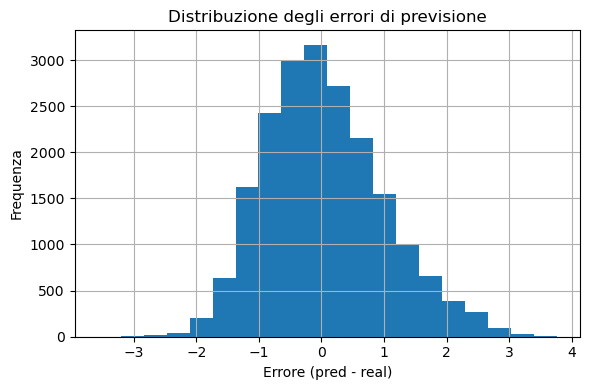

In [228]:
# Sezione 8: Distribuzione degli errori
ds = pd.DataFrame({'truth': y_true_cont, 'pred': y_pred_cont})
ds['error'] = ds['pred'] - ds['truth']
plt.figure(figsize=(6,4))
ds['error'].hist(bins=20)
plt.xlabel('Errore (pred - real)')
plt.ylabel('Frequenza')
plt.title('Distribuzione degli errori di previsione')
plt.tight_layout()
plt.show()

In [229]:
# Sezione 9: Funzione light per metrica Top-N utente single
train_user_items = train_data.groupby('user_id')['movie_id'].apply(set).to_dict()
test_user_actual = test_data[test_data.rating >= 4].groupby('user_id')['movie_id'].apply(set).to_dict()

def precision_recall_user(u, P_hybrid, train_user_items, test_user_actual, k=10):
    row = P_hybrid[u-1]
    seen = train_user_items.get(u, set())
    mask = np.ones_like(row, dtype=bool)
    mask[list(seen)] = False
    scores = row[mask]
    topk_idx = np.argpartition(-scores, k)[:k]
    all_items = np.arange(row.shape[0])[mask]
    topk_items = set(all_items[topk_idx])
    actual = test_user_actual.get(u, set())
    if not actual:
        return None, None
    hits = len(topk_items & actual)
    return hits/k, hits/len(actual)

In [230]:

# Sezione 10: Costruzione efficiente matrice P_hybrid
user_centered = train_matrix.sub(user_means, axis=0)
# Calcolo vettoriale di P_hybrid
# user-based
den_u = np.abs(user_similarity).sum(axis=1).to_numpy().reshape(-1,1)
P_u = user_similarity.dot(user_centered) / den_u + user_means.to_numpy().reshape(-1,1)
# item-based
den_i = np.abs(item_similarity).sum(axis=1).to_numpy().reshape(1,-1)
P_i = user_centered.dot(item_similarity) / den_i + user_means.to_numpy().reshape(-1,1)
# matrice ibrida
P_hybrid = 0.5 * (P_u + P_i)
# Converti in numpy array per accesso per posizione
P_hybrid = P_hybrid.to_numpy() if hasattr(P_hybrid, 'to_numpy') else P_hybrid

In [231]:
# Sezione 11: Calcolo medio Precision/Recall@5 su tutti gli utenti
k = 10  # modifica qui il valore di k

# Mapping user_id -> indice riga e movie_id -> indice colonna
user_to_idx = {uid: idx for idx, uid in enumerate(train_matrix.index)}
movie_to_idx = {mid: idx for idx, mid in enumerate(train_matrix.columns)}

train_items = train_data.groupby('user_id')['movie_id'].apply(set).to_dict()
test_items = test_data[test_data.rating >= 4].groupby('user_id')['movie_id'].apply(set).to_dict()

precisions, recalls = [], []
for u, actual in test_items.items():
    idx = user_to_idx.get(u)
    if idx is None:
        continue
    row = P_hybrid[idx]
    # crea maschera escludendo gli item visti
    mask = np.ones(row.shape, dtype=bool)
    seen = train_items.get(u, set())
    seen_idx = [movie_to_idx[m] for m in seen if m in movie_to_idx]
    mask[seen_idx] = False

    scores = row[mask]
    if scores.size < k:
        continue
    topk_idx = np.argpartition(-scores, k)[:k]
    candidates = np.arange(row.shape[0])[mask]
    topk_items = set(candidates[topk_idx])
    hits = len(topk_items & {movie_to_idx[m] for m in actual if m in movie_to_idx})
    precisions.append(hits / k)
    recalls.append(hits / len(actual))

if precisions:
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    print(f"Avg Precision@{k}: {avg_precision:.4f}")
    print(f"Avg Recall@{k}:    {avg_recall:.4f}")
else:
    print(f"Nessun utente valido per il calcolo delle metriche Top-{k}.")


Avg Precision@10: 0.2178
Avg Recall@10:    0.2262


In [232]:
def mostra_top10_utente(u_id, P_hybrid, train_data, test_data, movie_to_idx, train_matrix, k=10):
    if u_id not in train_matrix.index:
        print(f"L'utente {u_id} non è nel train set.")
        return

    user_idx = train_matrix.index.get_loc(u_id)
    row = P_hybrid[user_idx]

    seen = train_data[train_data.user_id == u_id]['movie_id'].tolist()
    seen_idx = [movie_to_idx[m] for m in seen if m in movie_to_idx]
    mask = np.ones_like(row, dtype=bool)
    mask[seen_idx] = False

    scores = row[mask]
    if scores.size < k:
        print("Utente con pochi film da raccomandare.")
        return

    topk_idx = np.argpartition(-scores, k)[:k]
    all_items = np.arange(row.shape[0])[mask]
    topk_items_idx = all_items[topk_idx]
    topk_movie_ids = [list(movie_to_idx.keys())[list(movie_to_idx.values()).index(i)] for i in topk_items_idx]

    relevant_movies = test_data[(test_data.user_id == u_id) & (test_data.rating >= 4)]['movie_id'].tolist()
    hits = set(topk_movie_ids) & set(relevant_movies)

    print(f"\n🎯 Utente {u_id}")
    print(f"Top-{k} consigliati:         {topk_movie_ids}")
    print(f"Film apprezzati (test ≥4):   {relevant_movies}")
    print(f"Hit consigliati:             {list(hits)}")


In [233]:
mostra_top10_utente(42, P_hybrid, train_data, test_data, movie_to_idx, train_matrix)



🎯 Utente 42
Top-10 consigliati:         [174, 100, 56, 204, 127, 69, 22, 117, 7, 176]
Film apprezzati (test ≥4):   [469, 174, 204, 925, 69, 118, 196, 136, 380, 418, 71, 785, 941, 756, 230, 568, 161]
Hit consigliati:             [204, 69, 174]
